각 epoch에 따른 score 그래프를 첨부한 파일입니다.

In [1]:
# Default setup과 tile 함수 정의부입니다.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "3_classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from PIL import Image
from itertools import product
import glob
import cv2 as cv

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j+5, i+5, j+d-5, i+d-5)
        out = os.path.join(dir_out, f'{name}_{i//38}_{j//38}{ext}')
        img.crop(box).save(out)

아래 셀은 MNIST 데이터를 가져오고 X, y에 배정하는 내용입니다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

X, y = mnist["data"], mnist["target"] # X, y: pandas DataFrame
X, y = X.to_numpy(), y.to_numpy() # X, y: numpy array

In [3]:
X_beforeInsert, y_beforeInsert = X[0:0].copy(), y[0:0].copy()
X_forTest, y_forTest = X[0:0].copy(), y[0:0].copy()
# X_beforeInsert와 y_beforeInsert는 빈 ndarray

os 모듈을 import하고 파일들을 28 x 28 jpg 이미지 파일로 쪼개는 단계입니다. ⚠️ Directory 관련 안내: 상대 경로이므로 폴더를 재구성하지 마십시오.

### Training 데이터 추가하기
380 * 380 JPEG 이미지 파일을 /mnist_append/in 폴더에 추가하고 아레 셀을 실행하면 Training / Test Dataset에 3:1 비율로 추가됩니다.

In [4]:
path = sorted(glob.glob("mnist_append/in/*.jpg"))
print(path)
for i in range(len(path)):
    path[i] = os.path.basename(path[i])
    tile(path[i],"mnist_append/in" ,"mnist_append/out", 38)

['mnist_append/in\\dahoonlee1.jpg', 'mnist_append/in\\dahoonlee10.jpg', 'mnist_append/in\\dahoonlee11.jpg', 'mnist_append/in\\dahoonlee12.jpg', 'mnist_append/in\\dahoonlee13.jpg', 'mnist_append/in\\dahoonlee14.jpg', 'mnist_append/in\\dahoonlee15.jpg', 'mnist_append/in\\dahoonlee16.jpg', 'mnist_append/in\\dahoonlee17.jpg', 'mnist_append/in\\dahoonlee18.jpg', 'mnist_append/in\\dahoonlee19.jpg', 'mnist_append/in\\dahoonlee2.jpg', 'mnist_append/in\\dahoonlee20.jpg', 'mnist_append/in\\dahoonlee3.jpg', 'mnist_append/in\\dahoonlee4.jpg', 'mnist_append/in\\dahoonlee5.jpg', 'mnist_append/in\\dahoonlee6.jpg', 'mnist_append/in\\dahoonlee7.jpg', 'mnist_append/in\\dahoonlee8.jpg', 'mnist_append/in\\dahoonlee9.jpg', 'mnist_append/in\\heejuahn1.jpg', 'mnist_append/in\\heejuahn10.jpg', 'mnist_append/in\\heejuahn2.jpg', 'mnist_append/in\\heejuahn3.jpg', 'mnist_append/in\\heejuahn4.jpg', 'mnist_append/in\\heejuahn5.jpg', 'mnist_append/in\\heejuahn6.jpg', 'mnist_append/in\\heejuahn7.jpg', 'mnist_append/i

### For transfer image to array
아래 셀부터는 수집된 이미지를 배열로 전환하는 과정입니다.

Saving figure some_digit_plot
7번째의 X의 레이블은: 7


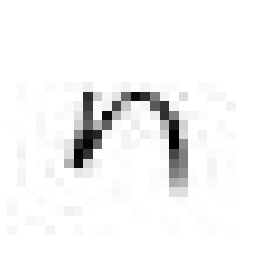

In [5]:
path = sorted(glob.glob("mnist_append/out/*.jpg"))

y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cv_img = []
for img in path:
    n = cv.imread(img, 0)
    n = 255 - n
    n = np.ravel(n, order='C')
    cv_img.append(n)

X_beforeInsert = np.concatenate((X_beforeInsert, cv_img), axis=0)
y_beforeInsert = np.append(y_beforeInsert, y_labels * (len(cv_img)//10))

a = 7 # want to know
some_digit = X_beforeInsert[a]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("some_digit_plot")
print(a, "번째의 X의 레이블은: ", y_beforeInsert[a], sep="")

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = X[:67500], X[67500:], y[:67500], y[67500:]
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_beforeInsert, y_beforeInsert, test_size=0.25, shuffle=True, stratify=y_beforeInsert, random_state=42)
X_train = np.concatenate((X_train, X_i_train), axis=0)
X_test = np.concatenate((X_test, X_i_test), axis=0)
y_train = np.append(y_train, y_i_train)
y_test = np.append(y_test, y_i_test)

0
Saving figure some_digit_plot
신규 데이터 중 train 데이터 비율: 0.75
신규 데이터 중 test 데이터 비율: 0.25
72075 4025 4025


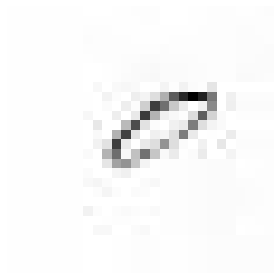

In [7]:
some_digit = X_test[2774]
print(y_test[2774])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("some_digit_plot")
print("신규 데이터 중 train 데이터 비율:", (len(X_train)-67500)/(len(X_train)-67500 + len(X_test)-2500))
print("신규 데이터 중 test 데이터 비율:", (len(X_test)-2500)/((len(X_train)-67500 + len(X_test)-2500)))
print(len(X_train), len(X_test), len(y_test))

KNN Classifier를 이용하여 초기 정확도 계산

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

print("Score of KNN:",accuracy_score(y_test, y_pred_knn))

Score of KNN: 0.7709316770186335


### 베이스라인이 너무 낮은 현상 발견
dataset을 조정한 후 KNN Classifiler 를 이용하여 정확도 다시 계산

In [9]:
#접근 폴더명을 제외한 나머지 설정은 초기 설정과 동일
#dataset 파일을 조정한 경우

X, y = mnist["data"], mnist["target"] # X, y: pandas DataFrame
X, y = X.to_numpy(), y.to_numpy() # X, y: numpy array

X_beforeInsert, y_beforeInsert = X[0:0].copy(), y[0:0].copy()
X_forTest, y_forTest = X[0:0].copy(), y[0:0].copy()
# X_beforeInsert와 y_beforeInsert는 빈 ndarray

path = sorted(glob.glob("mnist_append/out4/*.jpg"))

y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cv_img = []
for img in path:
    n = cv.imread(img, 0)
    n = 255 - n
    n = np.ravel(n, order='C')
    cv_img.append(n)

X_beforeInsert = np.concatenate((X_beforeInsert, cv_img), axis=0)
y_beforeInsert = np.append(y_beforeInsert, y_labels * (len(cv_img)//10))

X_train, X_test, y_train, y_test = X[:67500], X[67500:], y[:67500], y[67500:]
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_beforeInsert, y_beforeInsert, test_size=0.25, shuffle=True, stratify=y_beforeInsert, random_state=42)
X_train = np.concatenate((X_train, X_i_train), axis=0)
X_test = np.concatenate((X_test, X_i_test), axis=0)
y_train = np.append(y_train, y_i_train)
y_test = np.append(y_test, y_i_test)
print("신규 데이터 중 train 데이터 비율:", (len(X_train)-67500)/(len(X_train)-67500 + len(X_test)-2500))
print("신규 데이터 중 test 데이터 비율:", (len(X_test)-2500)/((len(X_train)-67500 + len(X_test)-2500)))
print(len(X_train), len(X_test), len(y_test))

신규 데이터 중 train 데이터 비율: 0.75
신규 데이터 중 test 데이터 비율: 0.25
72075 4025 4025


In [10]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

print("Score of KNN:",accuracy_score(y_test, y_pred_knn)) 

Score of KNN: 0.8104347826086956


In [11]:
#이후 train, test dataset의 비율을 조정한 경우

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_beforeInsert, y_beforeInsert, test_size=0.2, shuffle=True, stratify=y_beforeInsert, random_state=42)
X_train = np.concatenate((X_train, X_i_train), axis=0)
X_test = np.concatenate((X_test, X_i_test), axis=0)
y_train = np.append(y_train, y_i_train)
y_test = np.append(y_test, y_i_test)
print("신규 데이터 중 train 데이터 비율:", (len(X_train)-60000)/(len(X_train)-60000 + len(X_test)-10000))
print("신규 데이터 중 test 데이터 비율:", (len(X_test)-10000)/((len(X_train)-60000 + len(X_test)-10000)))
print(len(X_train), len(X_test), len(y_test))

신규 데이터 중 train 데이터 비율: 0.8
신규 데이터 중 test 데이터 비율: 0.2
64880 11220 11220


In [12]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

print("Score of KNN:",accuracy_score(y_test, y_pred_knn))

Score of KNN: 0.9194295900178253


### 데이터 scale 후 모델 fitting
다양한 방법으로 dataset을 scale한 후 각각의 모델에 대입 후 정확도, 소요 시간 도출

In [13]:
#confusion matrix 그림으로 보여주는 함수
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def draw_cm(model,label,predictions): #label은 y_train이나 y_test넣으면 된다.
    cm=confusion_matrix(label,predictions,labels=model.classes_)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [15]:
from sklearn.preprocessing import RobustScaler
rscaler=RobustScaler()
X_train_rscaled=rscaler.fit_transform(X_train)
X_test_rscaled=rscaler.transform(X_test)

In [16]:
from sklearn.preprocessing import MinMaxScaler
mscaler=MinMaxScaler()
X_train_mscaled=mscaler.fit_transform(X_train)
X_test_mscaled=mscaler.transform(X_test)

In [17]:
from sklearn.preprocessing import Normalizer
nor=Normalizer()
X_train_normalized=nor.fit_transform(X_train)
X_test_normalized=nor.transform(X_test)

In [10]:
scores={}
processing_times={}
predict_times={}

In [11]:
def fit_and_calScoreTime(clf,tr_data,ts_data,tr_label,ts_label):
    fit_st=time.time()
    clf.fit(tr_data,tr_label)
    fit_time=time.time()-fit_st
    
    pred_st=time.time()
    predictions=clf.predict(ts_data)
    pred_time=time.time()-pred_st
    
    score=accuracy_score(ts_label,predictions)
    return score,fit_time,pred_time

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import time

names=["SGD","LogisticRegression",
       "KNearest Neighbors",
       "Decision Tree",
       "Random Forest",
       "Multi-Layter Perceptron",
       "SVM",
       "Gaussian Naive Bayes",
       "Nearest Centroid","Multinomial Naive Bayes"]

classifiers=[
    SGDClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    SVC(),
    GaussianNB(),
    NearestCentroid(),
    MultinomialNB()
]

    
for name,clf in zip(names,classifiers):
    scaling_names=['No scaling','StandardScaler',"RobustScaler","MinMaxScaler","Normalizer"]
    t_scores=[]
    t_fit_times=[]
    t_pred_times=[]
    
    #no scaling
    score,fit_time,pred_time=fit_and_calScoreTime(clf,X_train,X_test,y_train,y_test)
    t_scores.append(score)
    t_fit_times.append(fit_time)
    t_pred_times.append(pred_time)
    
    try:
        #standardScaler
        sscore,sfit_time,spred_time=fit_and_calScoreTime(clf,X_train_scaled,X_test_scaled,y_train,y_test)
        t_scores.append(sscore)
        t_fit_times.append(sfit_time)
        t_pred_times.append(spred_time)
    
        #robustScaler
        rscore,rfit_time,rpred_time=fit_and_calScoreTime(clf,X_train_rscaled,X_test_rscaled,y_train,y_test)
        t_scores.append(rscore)
        t_fit_times.append(rfit_time)
        t_pred_times.append(rpred_time)
    
        #minmaxScaler
        mscore,mfit_time,mpred_time=fit_and_calScoreTime(clf,X_train_mscaled,X_test_mscaled,y_train,y_test)
        t_scores.append(mscore)
        t_fit_times.append(mfit_time)
        t_pred_times.append(mpred_time)
    
        #normalizer
        nscore,nfit_time,npred_time=fit_and_calScoreTime(clf,X_train_normalized,X_test_normalized,y_train,y_test)
        t_scores.append(nscore)
        t_fit_times.append(nfit_time)
        t_pred_times.append(npred_time)
    
        for i in range(len(scaling_names)):
            input_name=name+'('+scaling_names[i]+')'
            print(f"[{name} ({scaling_names[i]})] score: {t_scores[i]}, training time : {t_fit_times[i]}, prediction time : {t_pred_times[i]}")
            scores[input_name]=t_scores[i]
            processing_times[input_name]=t_fit_times[i]
            predict_times[input_name]=t_pred_times[i]
            
    except ValueError:
        continue

D:\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[SGD (No scaling)] score: 0.8148841354723708, training time : 223.8643832206726, prediction time : 0.04388856887817383
[SGD (StandardScaler)] score: 0.7997326203208556, training time : 647.8173587322235, prediction time : 0.0449521541595459
[SGD (RobustScaler)] score: 0.7866310160427807, training time : 188.7007613182068, prediction time : 0.044850826263427734
[SGD (MinMaxScaler)] score: 0.8467023172905526, training time : 24.9798367023468, prediction time : 0.05560135841369629
[SGD (Normalizer)] score: 0.8364527629233511, training time : 10.364108800888062, prediction time : 0.05012822151184082


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

[LogisticRegression (No scaling)] score: 0.8529411764705882, training time : 40.457287311553955, prediction time : 0.04878950119018555
[LogisticRegression (StandardScaler)] score: 0.8572192513368984, training time : 32.42841720581055, prediction time : 0.0665583610534668
[LogisticRegression (RobustScaler)] score: 0.7411764705882353, training time : 33.61509704589844, prediction time : 0.044316768646240234
[LogisticRegression (MinMaxScaler)] score: 0.8549910873440285, training time : 34.084877729415894, prediction time : 0.048879146575927734
[LogisticRegression (Normalizer)] score: 0.8513368983957219, training time : 35.34672999382019, prediction time : 0.045879364013671875
[KNearest Neighbors (No scaling)] score: 0.9194295900178253, training time : 0.15093517303466797, prediction time : 41.17000102996826
[KNearest Neighbors (StandardScaler)] score: 0.8982174688057041, training time : 0.19999217987060547, prediction time : 40.5444655418396
[KNearest Neighbors (RobustScaler)] score: 0.70

In [21]:
#비교하는 cell
import operator
#각각 딕셔너리 내림차순으로 정렬하기위해서 list형식으로 바뀜
#(('svm',숫자),('mlp',숫자), ... ) <--이런 형식으로 바뀜
sorted_scores=sorted(scores.items(),key=operator.itemgetter(1),reverse=True)
sorted_processing_times=sorted(processing_times.items(),key=operator.itemgetter(1))
sorted_predict_times=sorted(predict_times.items(),key=operator.itemgetter(1))

def print_n_best_models(list,string,n): #list에서 상위 몇개를 출력하는 함수
    print(string)
    for i in range(n):
        key=list[i][0]
        print(key)
    print("")

print_n_best_models(sorted_scores,"[best 4 models in accuracy score]",4)
print_n_best_models(sorted_processing_times,"[best 4 models in training time]",4)
print_n_best_models(sorted_predict_times,"[best 4 models in prediction time]",4)


[best 4 models in accuracy score]
SVM(Normalizer)
Multi-Layter Perceptron(Normalizer)
Multi-Layter Perceptron(MinMaxScaler)
KNearest Neighbors(Normalizer)

[best 4 models in training time]
KNearest Neighbors(No scaling)
KNearest Neighbors(MinMaxScaler)
KNearest Neighbors(Normalizer)
KNearest Neighbors(RobustScaler)

[best 4 models in prediction time]
Decision Tree(StandardScaler)
Decision Tree(MinMaxScaler)
Decision Tree(Normalizer)
SGD(No scaling)



### 결과
1. [SVM (Normalizer)] score: 0.9470588235294117, training time : 411.2120499610901, prediction time : 133.91931772232056


2. [Multi-Layter Perceptron (Normalizer)] score: 0.9408199643493761, training time : 377.61616134643555, prediction time : 0.2149503231048584


3. [Multi-Layter Perceptron (MinMaxScaler)] score: 0.9396613190730838, training time : 130.91441988945007, prediction time : 0.0827791690826416


4. [KNearest Neighbors (Normalizer)] score: 0.935204991087344, training time : 0.16080307960510254, prediction time : 36.91610336303711


MLP와 SVM의 경우 정확도는 높지만 소요시간이 오래 걸리는 반면 KNN은 정확도는 다소 떨어지지만 소요시간이 현저히 줄어드는 것을 알 수 있다. 또한 Normalizer를 사용한 경우가 대체로 모델 성능을 향상시켜주는 것으로 보인다. (예측 시간이 가장 짧은 Decision Tree는 정확도가 떨어지는 관계로 사용하지 않음)

- KNN Classifier 최적의 조건 탐색 

In [22]:
for n in [1,2,3,4,5]:
    for weights in ['uniform', 'distance']:

    #st_tr = time.time()
        knn_nor_clf = KNeighborsClassifier(n_neighbors = n, weights = weights)
        knn_nor_clf.fit(X_train_normalized, y_train)
    #end_tr = time.time() - st_tr
    
    #st_ts = time.time()
        y_predict = knn_nor_clf.predict(X_test_normalized)
    #end_ts = time.time() - st_ts
    
        acc = accuracy_score(y_test, y_predict)
        print('n:', n, 'weights:', weights, '->', 'acc:', acc)

n: 1 weights: uniform -> acc: 0.9380570409982175
n: 1 weights: distance -> acc: 0.9380570409982175
n: 2 weights: uniform -> acc: 0.9303921568627451
n: 2 weights: distance -> acc: 0.9380570409982175
n: 3 weights: uniform -> acc: 0.9350267379679145
n: 3 weights: distance -> acc: 0.9399286987522282
n: 4 weights: uniform -> acc: 0.9358288770053476
n: 4 weights: distance -> acc: 0.9406417112299466
n: 5 weights: uniform -> acc: 0.935204991087344
n: 5 weights: distance -> acc: 0.9388591800356506


In [23]:
for n in [6,7,8,9,10]:
    for weights in ['uniform', 'distance']:

    #st_tr = time.time()
        knn_nor_clf = KNeighborsClassifier(n_neighbors = n, weights = weights)
        knn_nor_clf.fit(X_train_normalized, y_train)
    #end_tr = time.time() - st_tr
    
    #st_ts = time.time()
        y_predict = knn_nor_clf.predict(X_test_normalized)
    #end_ts = time.time() - st_ts
    
        acc = accuracy_score(y_test, y_predict)
        print('n:', n, 'weights:', weights, '->', 'acc:', acc)

n: 6 weights: uniform -> acc: 0.9331550802139037
n: 6 weights: distance -> acc: 0.9377005347593583
n: 7 weights: uniform -> acc: 0.932174688057041
n: 7 weights: distance -> acc: 0.9370766488413548
n: 8 weights: uniform -> acc: 0.9311051693404635
n: 8 weights: distance -> acc: 0.9370766488413548
n: 9 weights: uniform -> acc: 0.9288770053475935
n: 9 weights: distance -> acc: 0.9348484848484848
n: 10 weights: uniform -> acc: 0.9257575757575758
n: 10 weights: distance -> acc: 0.9339572192513369


-> n_neighbors = 4, weights = distance 일 때 최대, 하지만 SVM, MLP의 정확도를 넘지는 못함

Saving figure KNN learning_curve


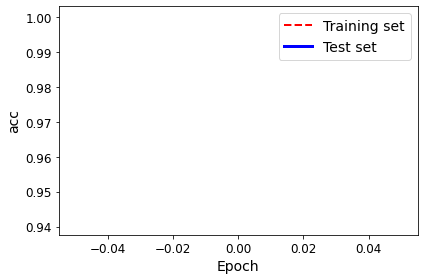

Saving figure KNN learning_curve


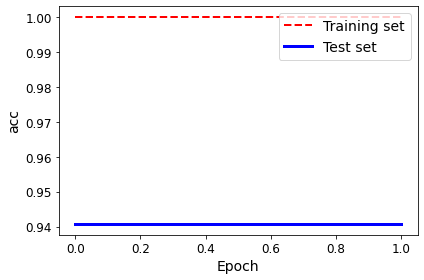

Saving figure KNN learning_curve


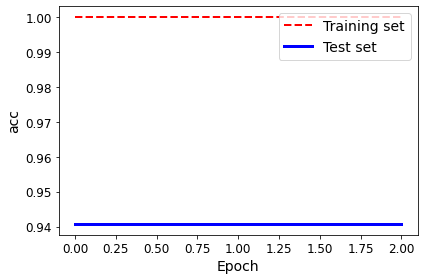

Saving figure KNN learning_curve


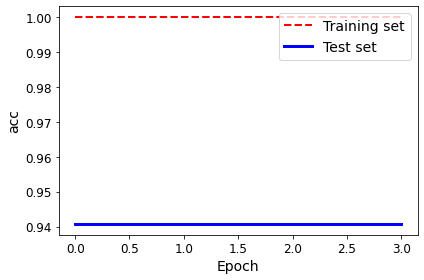

Saving figure KNN learning_curve


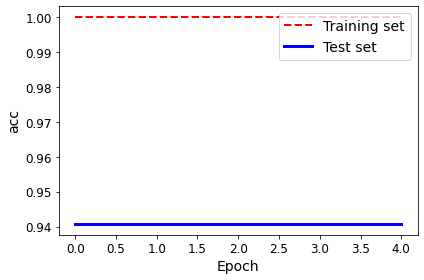

Saving figure KNN learning_curve


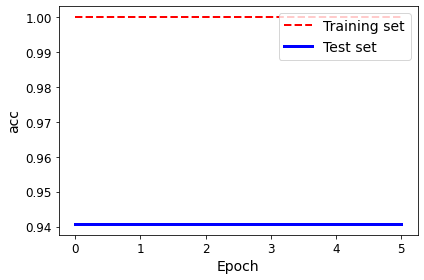

Saving figure KNN learning_curve


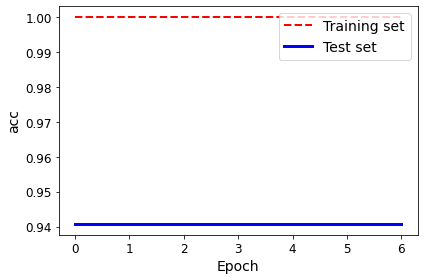

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_nor_clf = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
n_epochs = 10
train_acc,test_acc = [],[]
for epoch in range(n_epochs):
    knn_nor_clf.fit(X_train_normalized, y_train)
    train_acc.append(knn_nor_clf.score(X_train_normalized, y_train))
    test_acc.append(knn_nor_clf.score(X_test_normalized, y_test))
    #best_test_rmse -= 0.03  # just to make the graph look better
    plt.plot(train_acc, "r--", linewidth=2, label="Training set")
    plt.plot(test_acc, "b-", linewidth=3, label="Test set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    save_fig("KNN learning_curve")
    plt.show()

- MLP Classifier 최적의 조건 탐색 

In [24]:
#minmaxScaler
for a in [0.00001,0.0001,0.001,0.01, 0.1]:
    #for mi in [10,100,200,500,1000,2000]:

    mlp_mm_clf = MLPClassifier(alpha = a)
    mlp_mm_clf.fit(X_train_mscaled, y_train)

    y_predict = mlp_mm_clf.predict(X_test_mscaled)

    acc = accuracy_score(y_test, y_predict)
    print('a:', a,'->', 'acc:', acc)

a: 1e-05 -> acc: 0.9398395721925134
a: 0.0001 -> acc: 0.9412655971479501
a: 0.001 -> acc: 0.9427807486631016
a: 0.01 -> acc: 0.9435828877005348
a: 0.1 -> acc: 0.9462566844919786
a: 1 -> acc: 0.8920677361853833
a: 10 -> acc: 0.8114081996434938


In [26]:
for mi in [200,500,1000,2000]:

    mlp_mm_clf = MLPClassifier(alpha = 0.1, max_iter = mi, random_state = 42)
    mlp_mm_clf.fit(X_train_mscaled, y_train)

    y_predict = mlp_mm_clf.predict(X_test_mscaled)

    acc = accuracy_score(y_test, y_predict)
    print('mi:', mi,'->', 'acc:', acc)

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


mi: 10 -> acc: 0.931283422459893


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


mi: 100 -> acc: 0.9441176470588235
mi: 200 -> acc: 0.9450980392156862
mi: 500 -> acc: 0.9449197860962567
mi: 1000 -> acc: 0.9477718360071301
mi: 2000 -> acc: 0.9453654188948306


-> alpha = 0.1, max_iter = 200  일 때 최대

Saving figure learning_curve


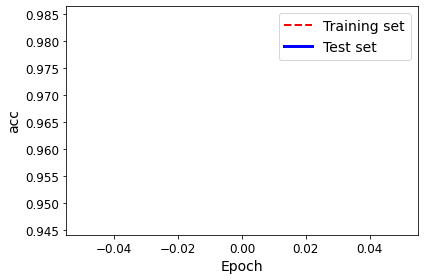

Saving figure learning_curve


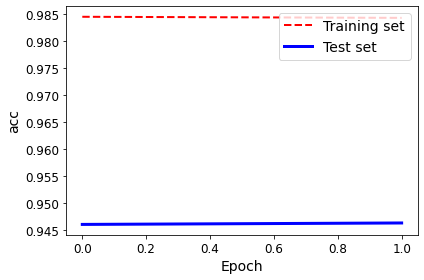

Saving figure learning_curve


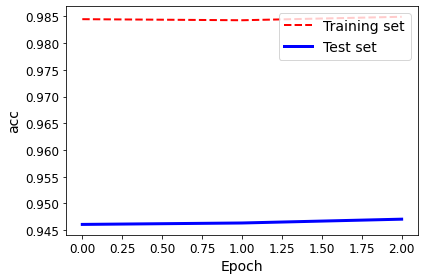

Saving figure learning_curve


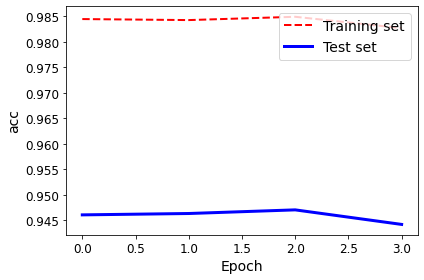

Saving figure learning_curve


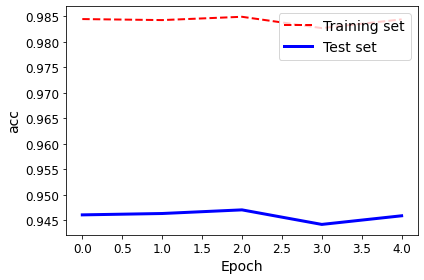

Saving figure learning_curve


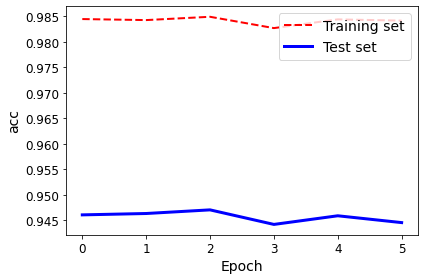

Saving figure learning_curve


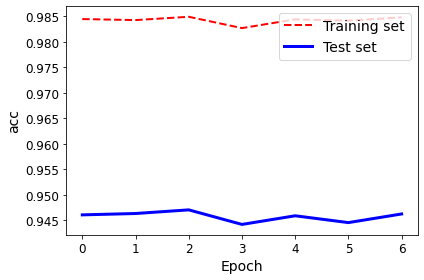

Saving figure learning_curve


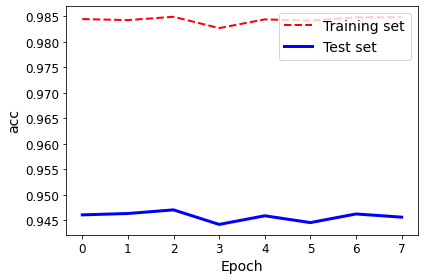

Saving figure learning_curve


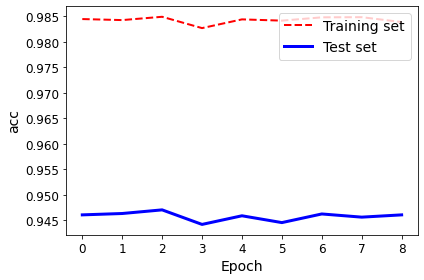

Saving figure learning_curve


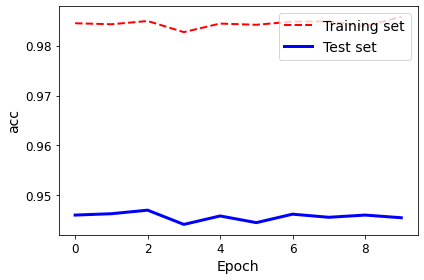

Saving figure learning_curve


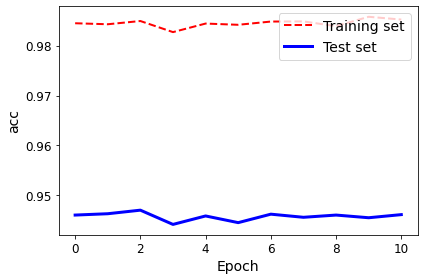

Saving figure learning_curve


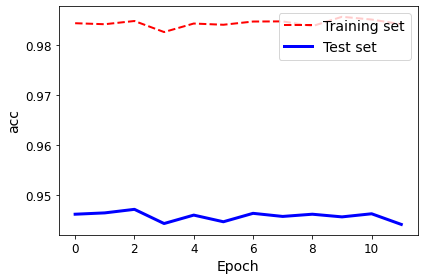

Saving figure learning_curve


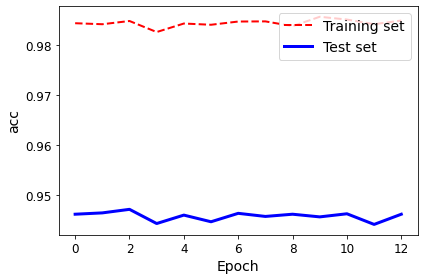

Saving figure learning_curve


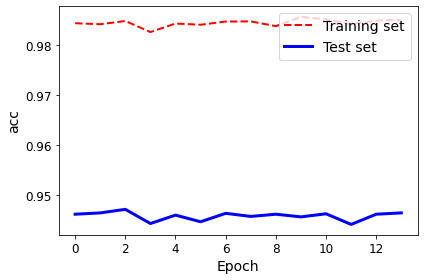

Saving figure learning_curve


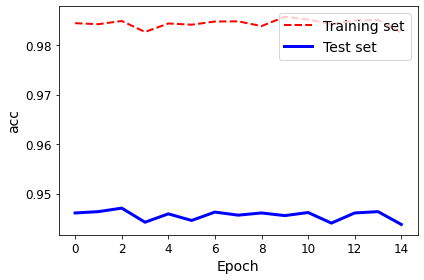

Saving figure learning_curve


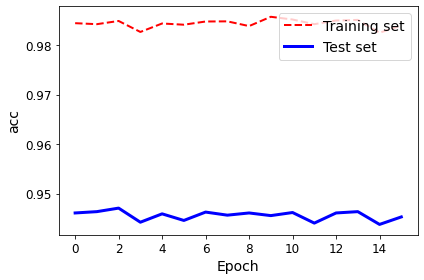

Saving figure learning_curve


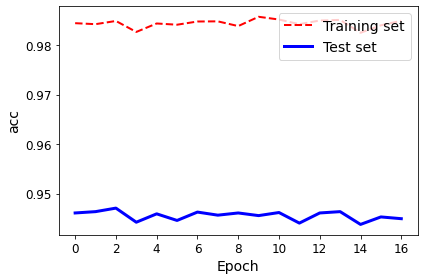

Saving figure learning_curve


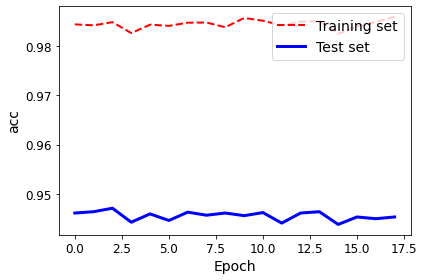

Saving figure learning_curve


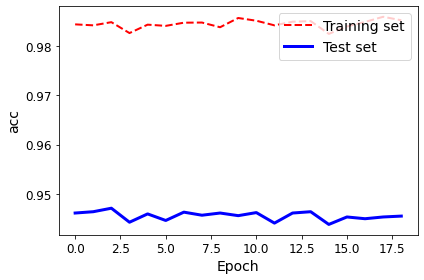

Saving figure learning_curve


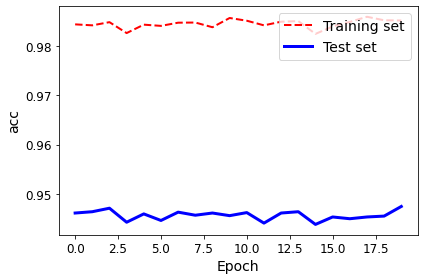

Saving figure learning_curve


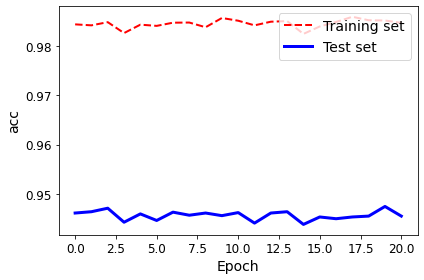

Saving figure learning_curve


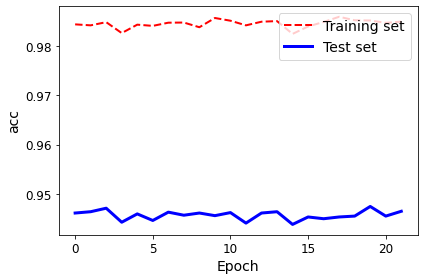

Saving figure learning_curve


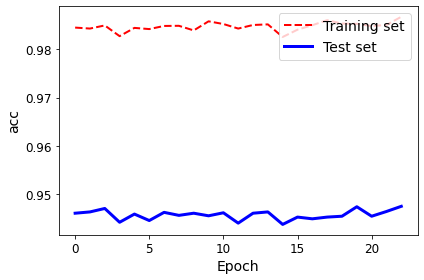

Saving figure learning_curve


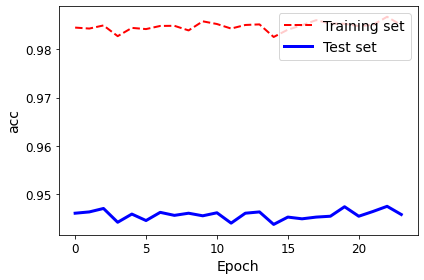

Saving figure learning_curve


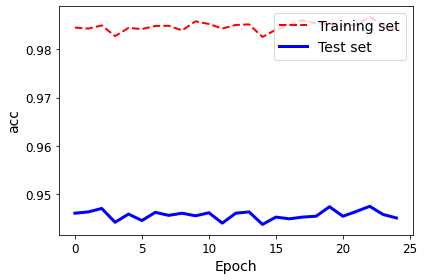

Saving figure learning_curve


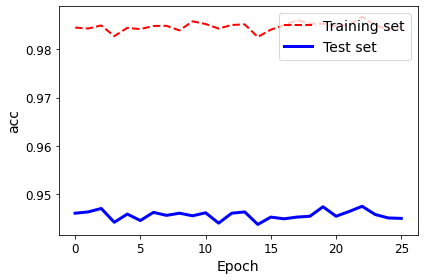

Saving figure learning_curve


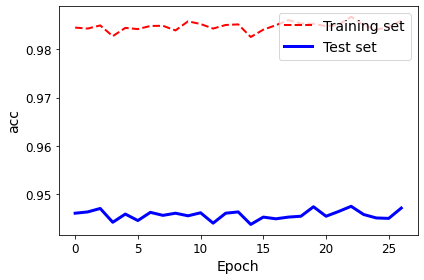

Saving figure learning_curve


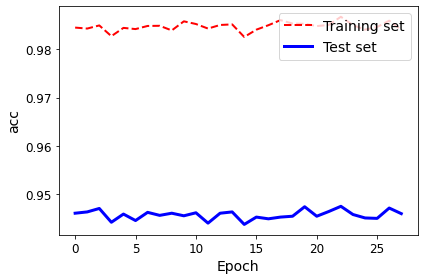

Saving figure learning_curve


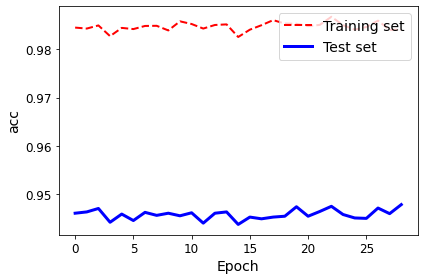

Saving figure learning_curve


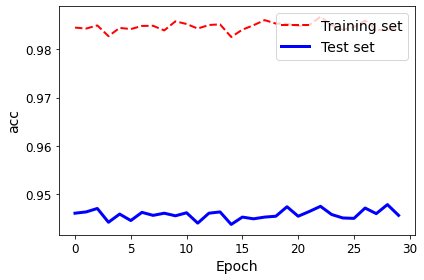

Saving figure learning_curve


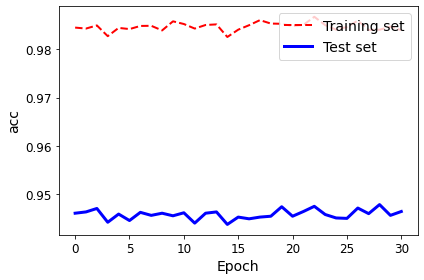

Saving figure learning_curve


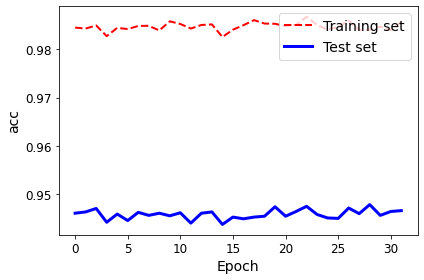

Saving figure learning_curve


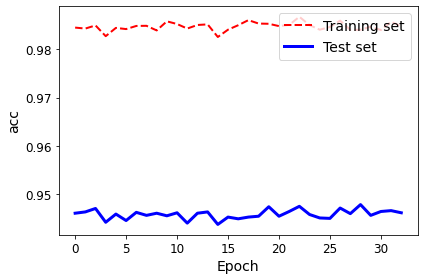

Saving figure learning_curve


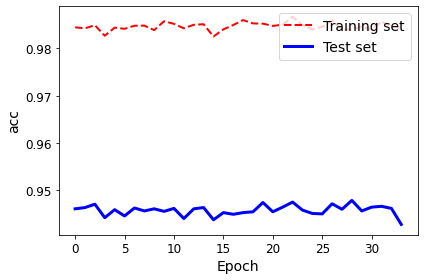

Saving figure learning_curve


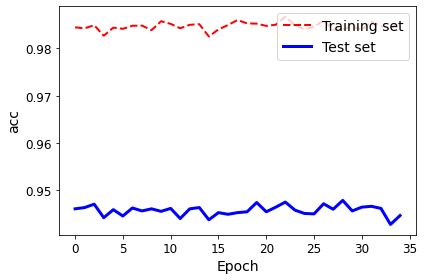

Saving figure learning_curve


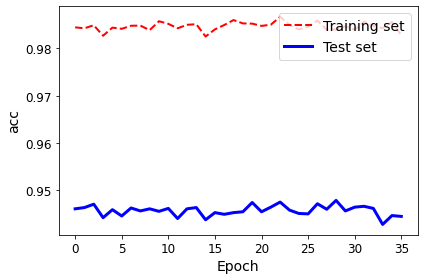

Saving figure learning_curve


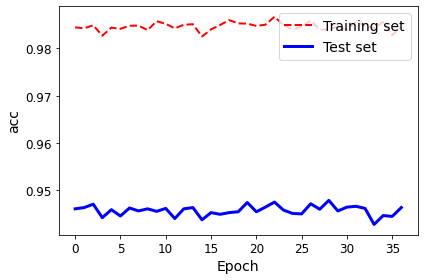

Saving figure learning_curve


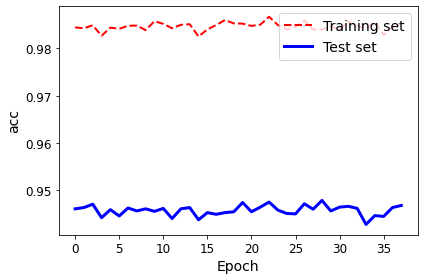

Saving figure learning_curve


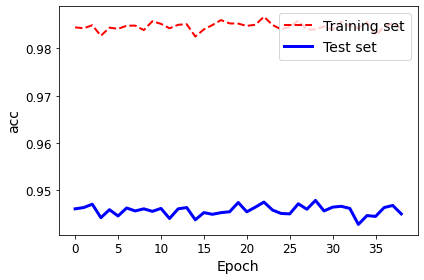

Saving figure learning_curve


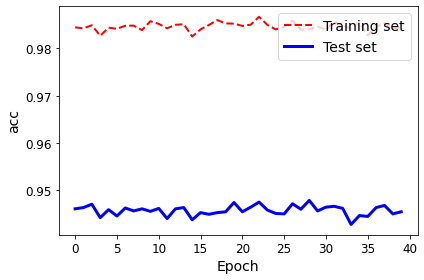

Saving figure learning_curve


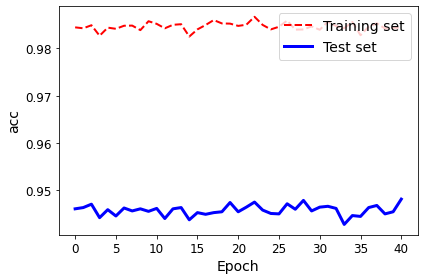

Saving figure learning_curve


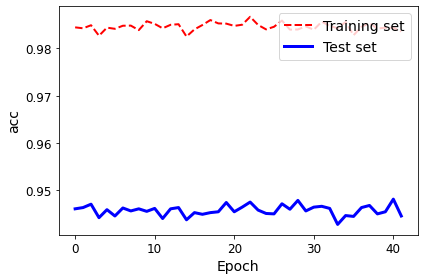

Saving figure learning_curve


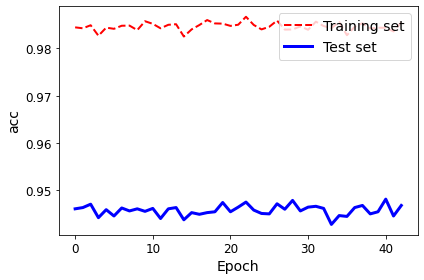

Saving figure learning_curve


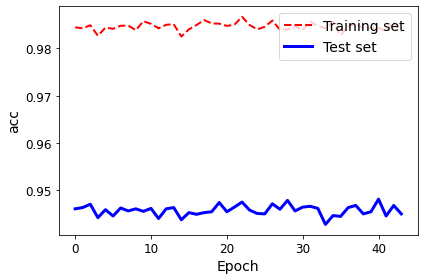

Saving figure learning_curve


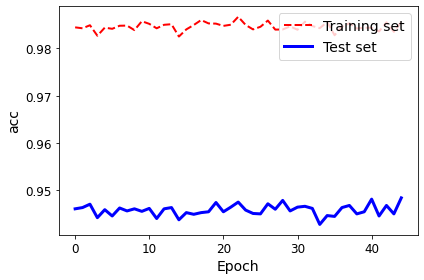

Saving figure learning_curve


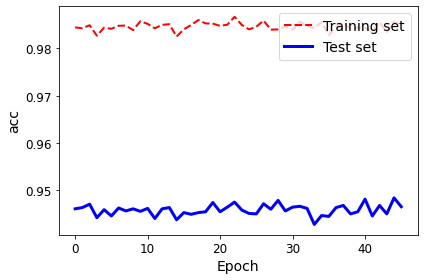

Saving figure learning_curve


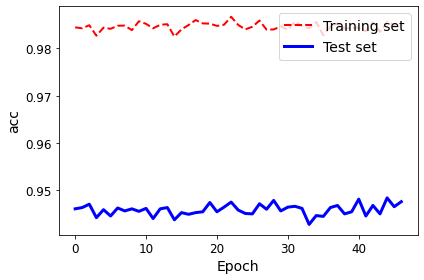

Saving figure learning_curve


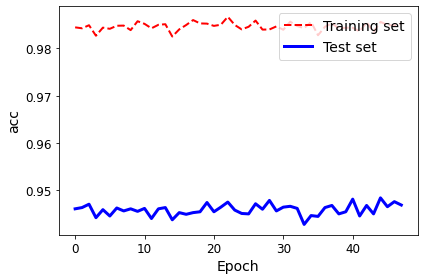

Saving figure learning_curve


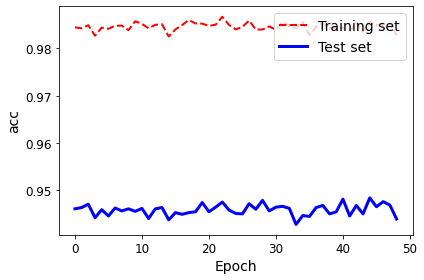

Saving figure learning_curve


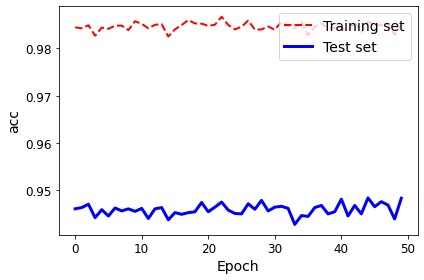

Saving figure learning_curve


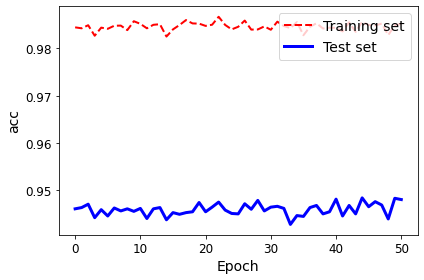

Saving figure learning_curve


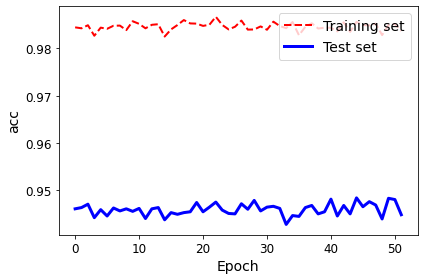

Saving figure learning_curve


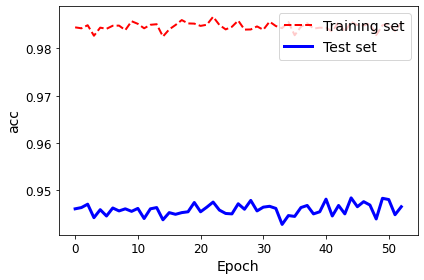

Saving figure learning_curve


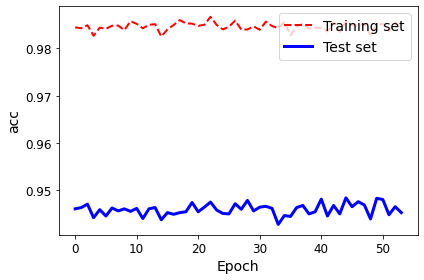

Saving figure learning_curve


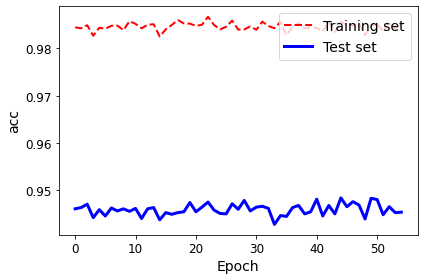

Saving figure learning_curve


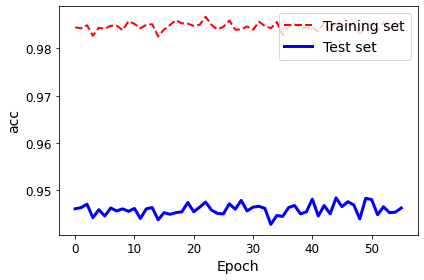

Saving figure learning_curve


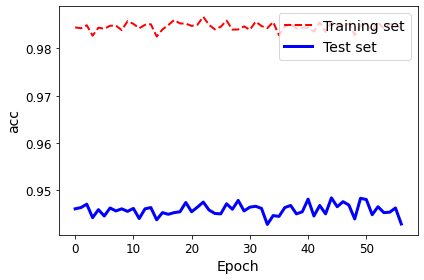

Saving figure learning_curve


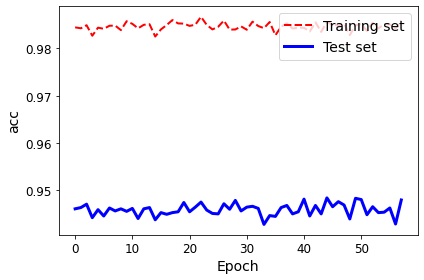

Saving figure learning_curve


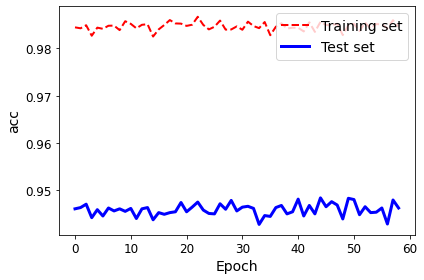

Saving figure learning_curve


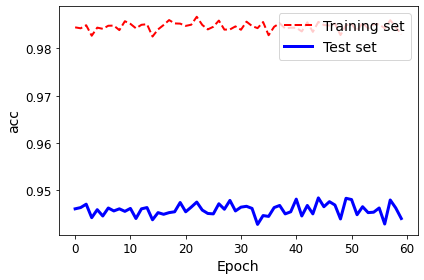

Saving figure learning_curve


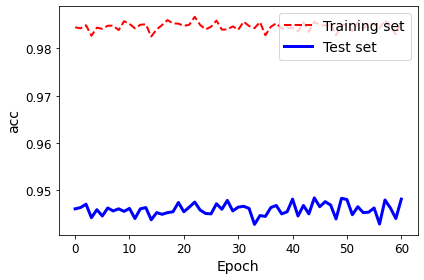

Saving figure learning_curve


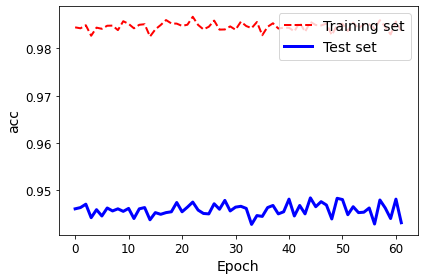

Saving figure learning_curve


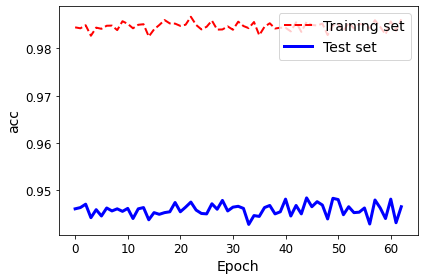

Saving figure learning_curve


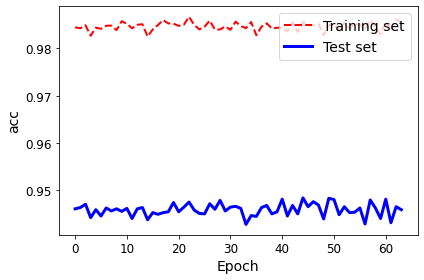

Saving figure learning_curve


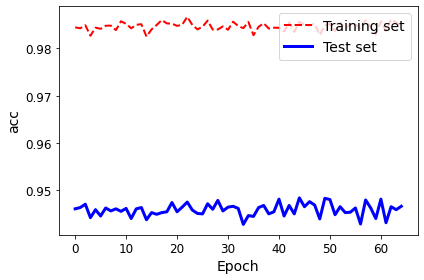

Saving figure learning_curve


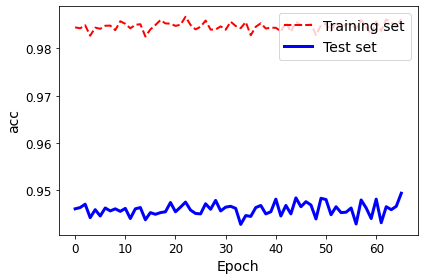

Saving figure learning_curve


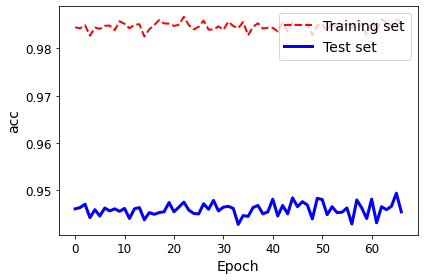

Saving figure learning_curve


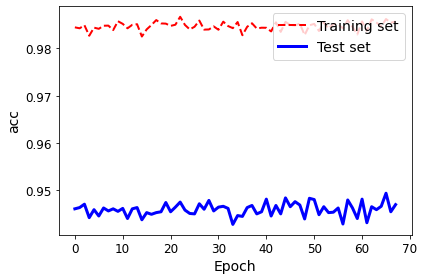

Saving figure learning_curve


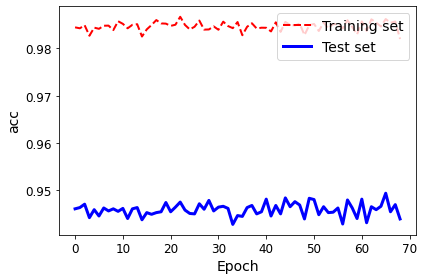

Saving figure learning_curve


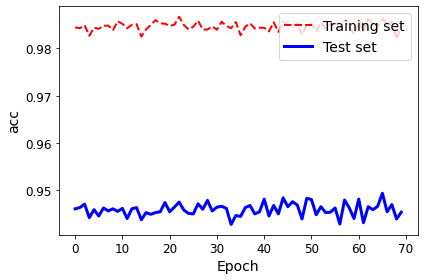

Saving figure learning_curve


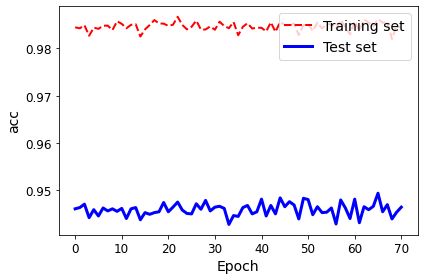

Saving figure learning_curve


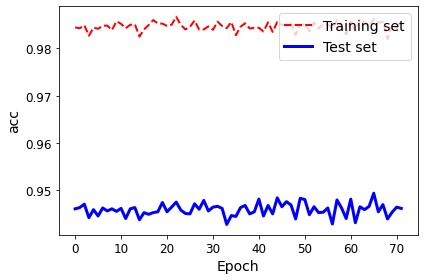

Saving figure learning_curve


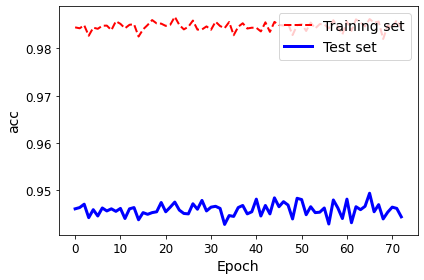

Saving figure learning_curve


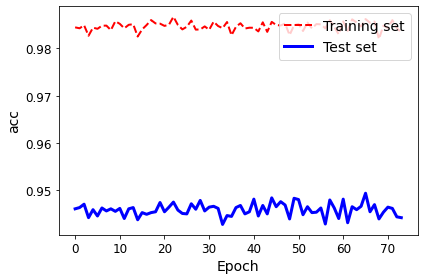

Saving figure learning_curve


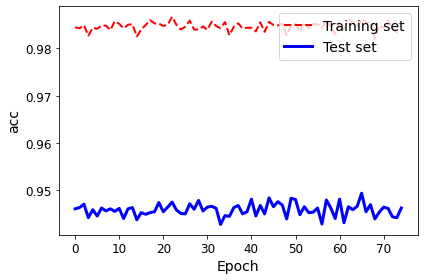

Saving figure learning_curve


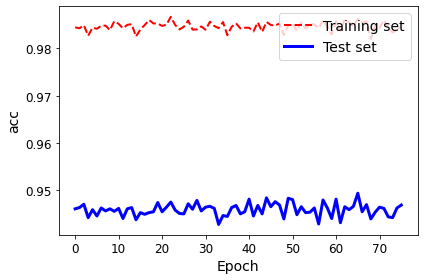

Saving figure learning_curve


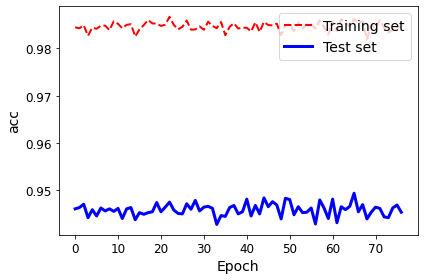

Saving figure learning_curve


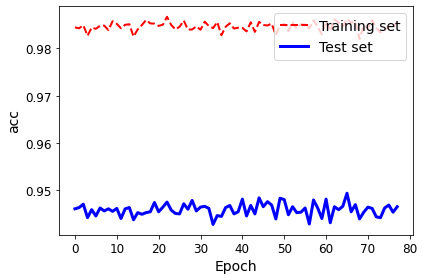

Saving figure learning_curve


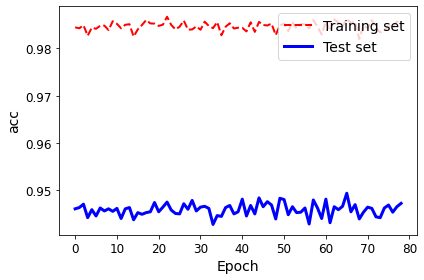

Saving figure learning_curve


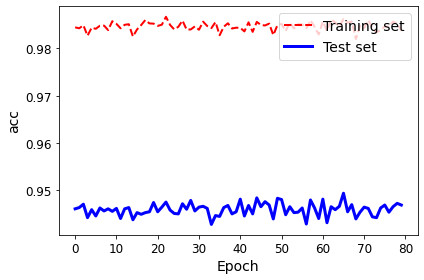

Saving figure learning_curve


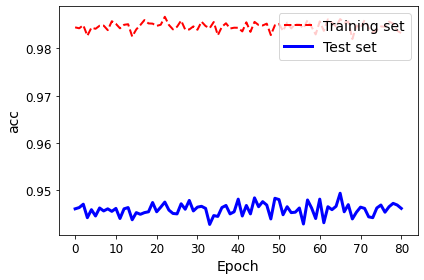

Saving figure learning_curve


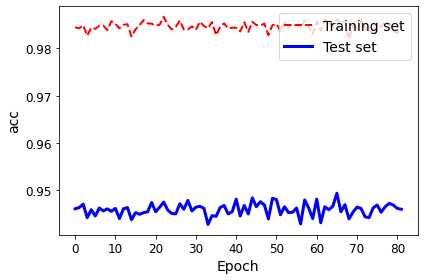

Saving figure learning_curve


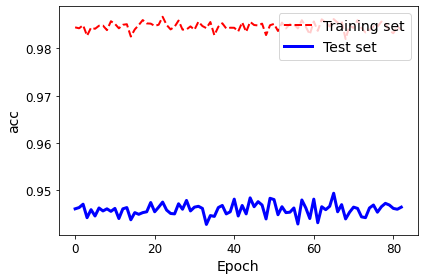

Saving figure learning_curve


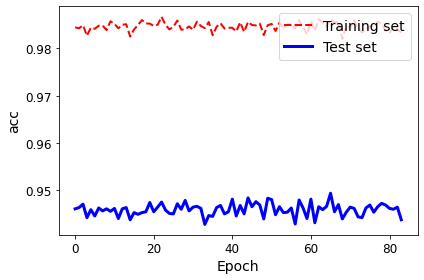

Saving figure learning_curve


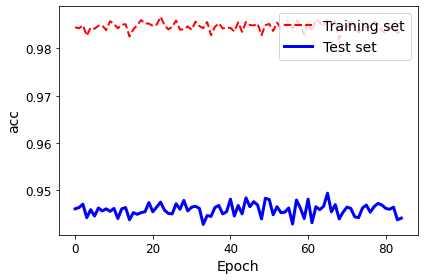

Saving figure learning_curve


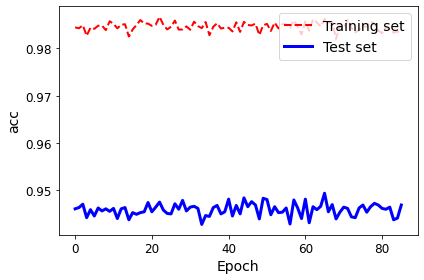

Saving figure learning_curve


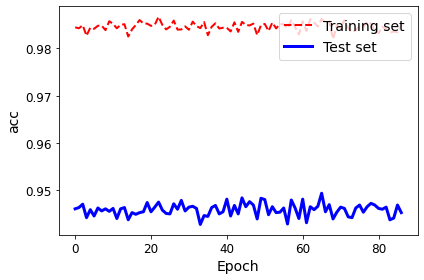

Saving figure learning_curve


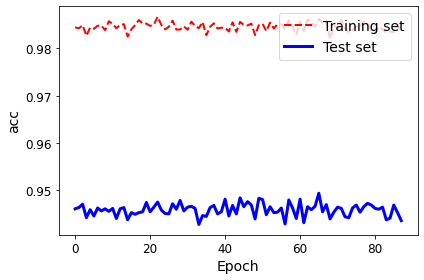

Saving figure learning_curve


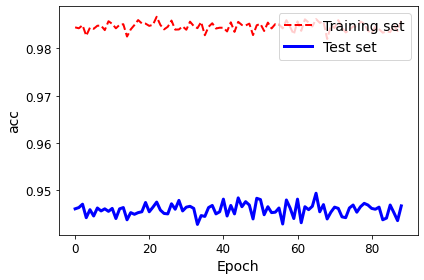

Saving figure learning_curve


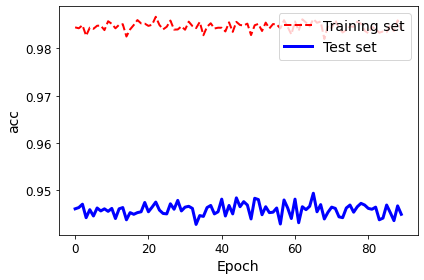

Saving figure learning_curve


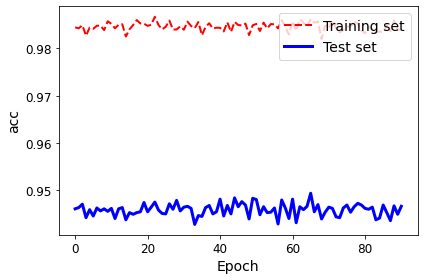

Saving figure learning_curve


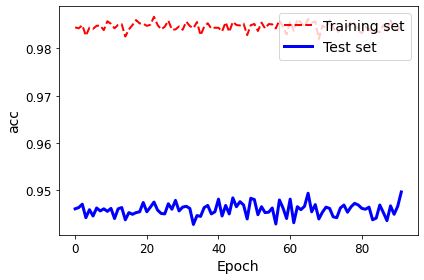

Saving figure learning_curve


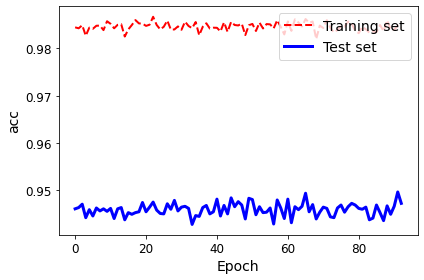

Saving figure learning_curve


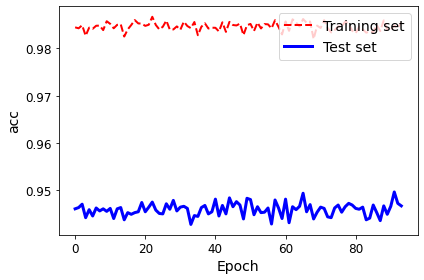

Saving figure learning_curve


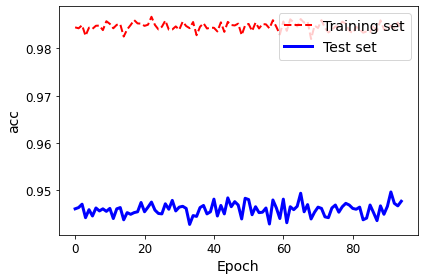

Saving figure learning_curve


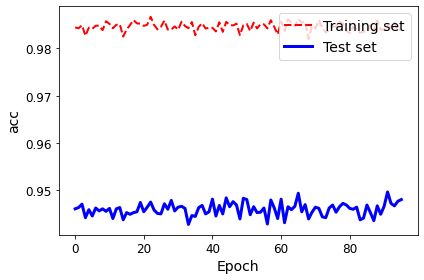

Saving figure learning_curve


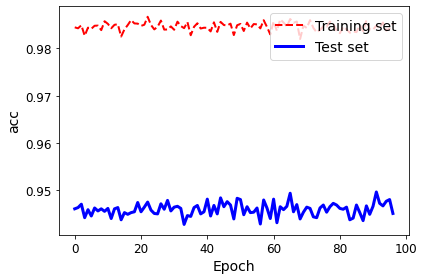

Saving figure learning_curve


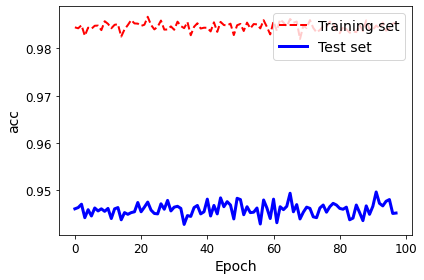

Saving figure learning_curve


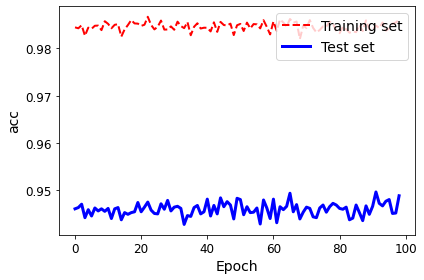

Saving figure learning_curve


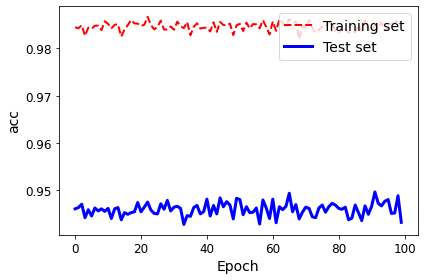

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
mlp_mm_clf = MLPClassifier(alpha = 0.1, max_iter = 200, random_state= 42)
n_epochs = 100
train_acc,test_acc = [],[]
for epoch in range(n_epochs):
    mlp_mm_clf.fit(X_train_mscaled, y_train)
    train_acc.append(mlp_mm_clf.score(X_train_mscaled, y_train))
    test_acc.append(mlp_mm_clf.score(X_test_mscaled, y_test))
    #best_test_rmse -= 0.03  # just to make the graph look better
    plt.plot(train_acc, "r--", linewidth=2, label="Training set")
    plt.plot(test_acc, "b-", linewidth=3, label="Test set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    save_fig("learning_curve")
    plt.show()

In [19]:
#normalScaler
from sklearn.neural_network import MLPClassifier
for a in [0.00001,0.0001,0.001,0.01, 0.1]:
    mlp_nor_clf = MLPClassifier(alpha = a)
    mlp_nor_clf.fit(X_train_normalized, y_train)

    y_predict = mlp_nor_clf.predict(X_test_normalized)

    acc = accuracy_score(y_test, y_predict)
    print('a:', a,'->', 'acc:', acc)

a: 1e-05 -> acc: 0.941711229946524
a: 0.0001 -> acc: 0.9409090909090909
a: 0.001 -> acc: 0.9422459893048128


C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


a: 0.01 -> acc: 0.9457219251336898
a: 0.1 -> acc: 0.9101604278074866


-> alpha = 0.01 일 때 최대

Saving figure MLP_nor_clf_learning_curve


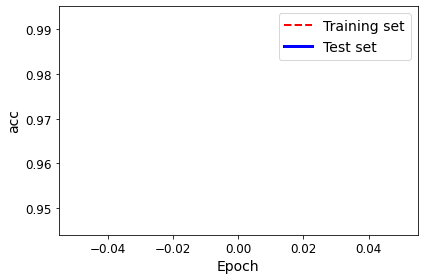

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


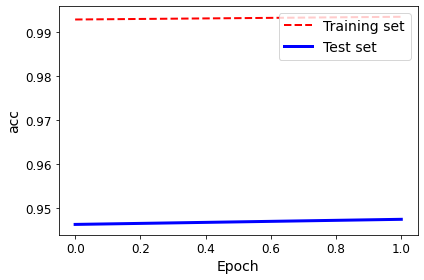

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


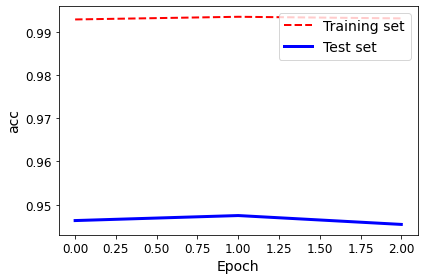

Saving figure MLP_nor_clf_learning_curve


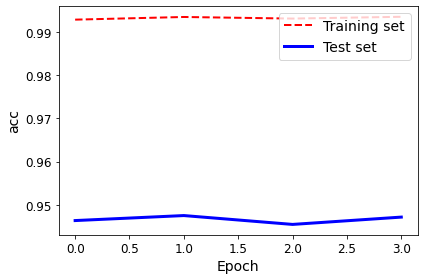

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


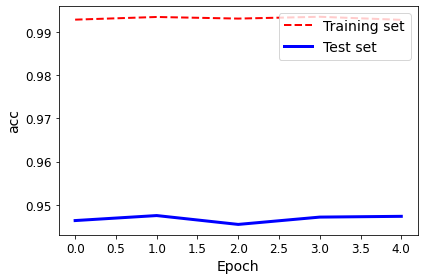

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


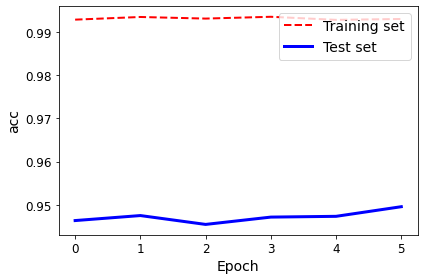

Saving figure MLP_nor_clf_learning_curve


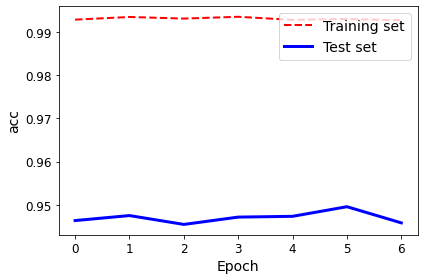

Saving figure MLP_nor_clf_learning_curve


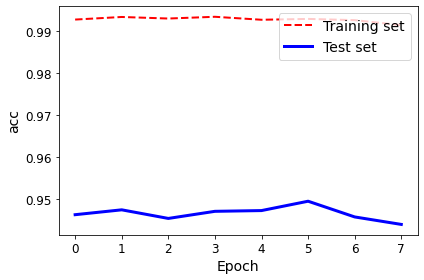

Saving figure MLP_nor_clf_learning_curve


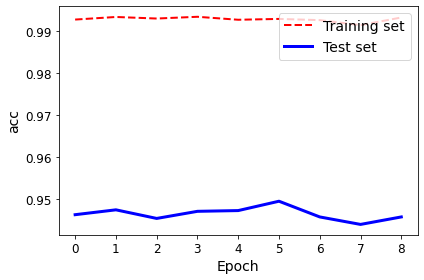

Saving figure MLP_nor_clf_learning_curve


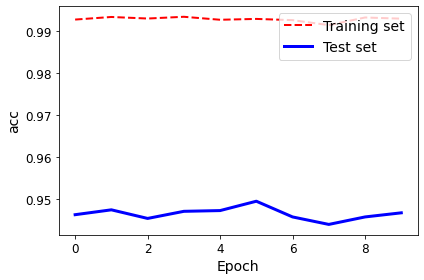

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


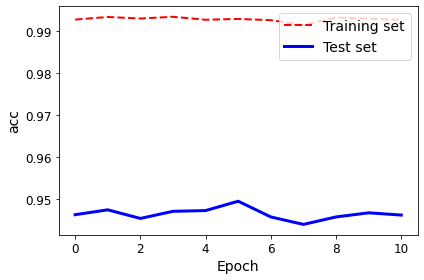

Saving figure MLP_nor_clf_learning_curve


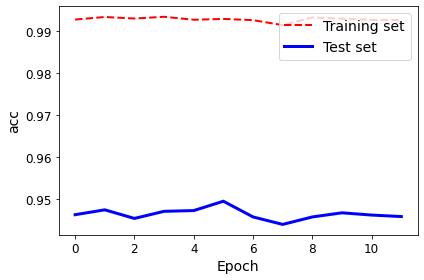

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


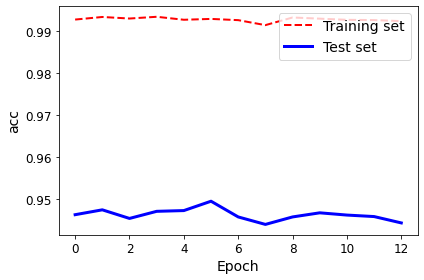

Saving figure MLP_nor_clf_learning_curve


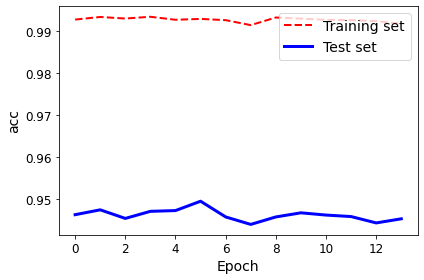

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


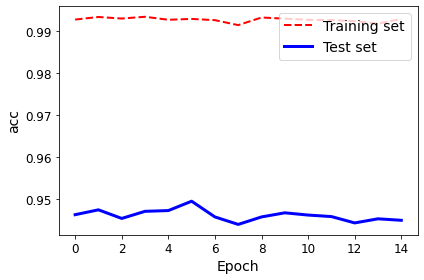

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


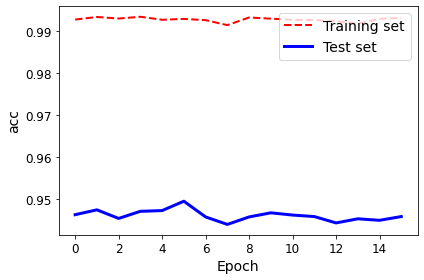

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


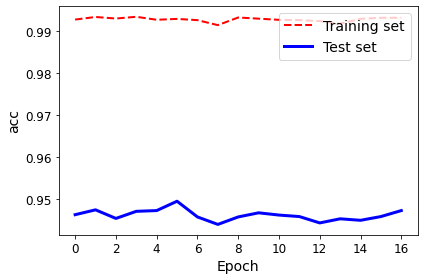

Saving figure MLP_nor_clf_learning_curve


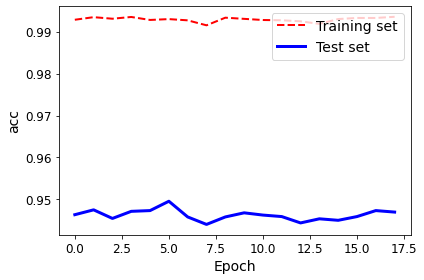

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


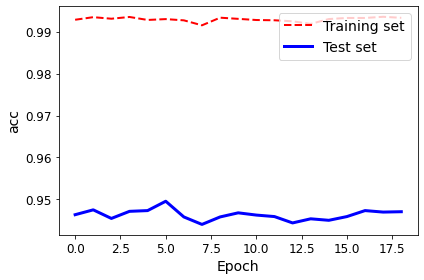

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


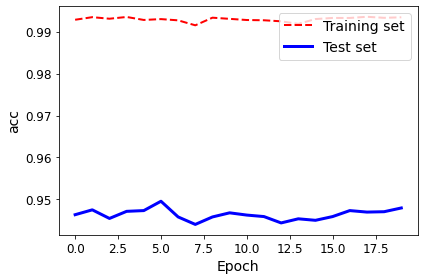

Saving figure MLP_nor_clf_learning_curve


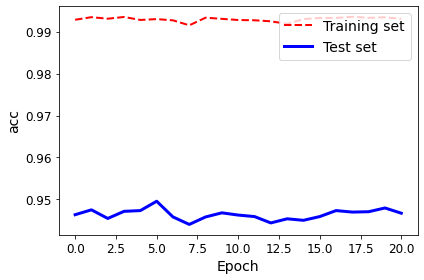

Saving figure MLP_nor_clf_learning_curve


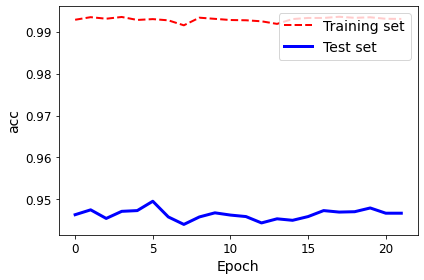

Saving figure MLP_nor_clf_learning_curve


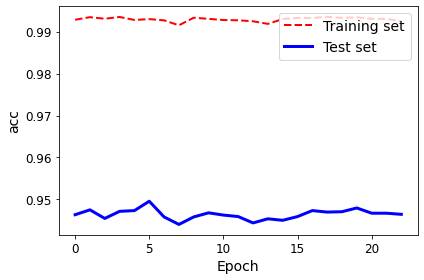

Saving figure MLP_nor_clf_learning_curve


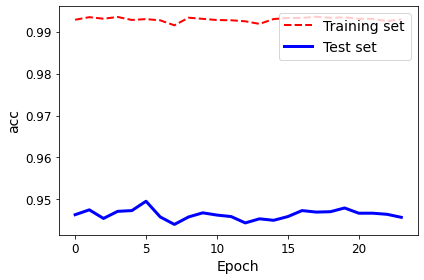

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


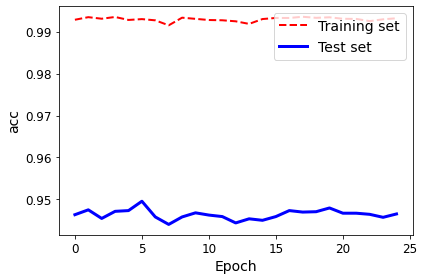

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


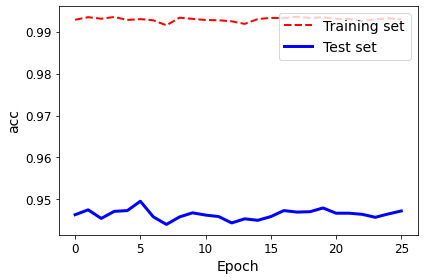

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


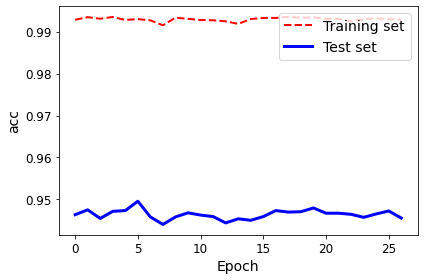

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


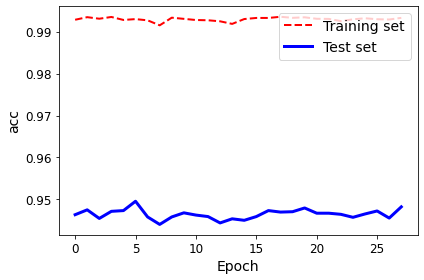

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


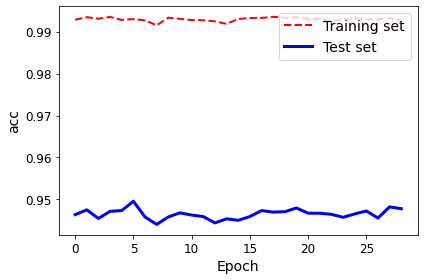

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


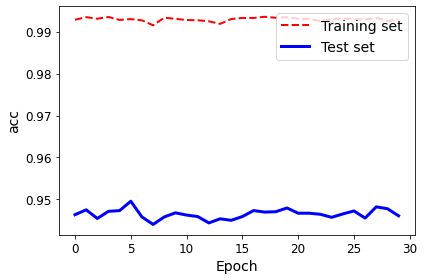

Saving figure MLP_nor_clf_learning_curve


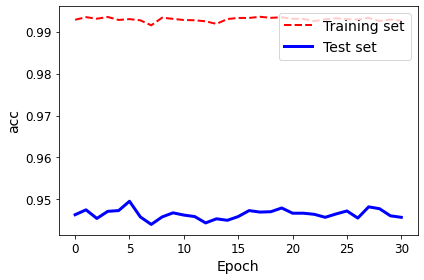

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


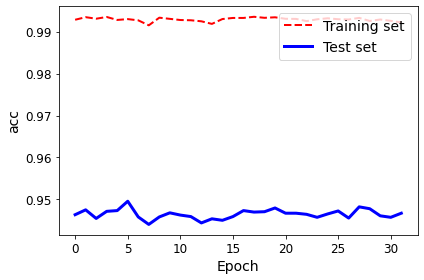

Saving figure MLP_nor_clf_learning_curve


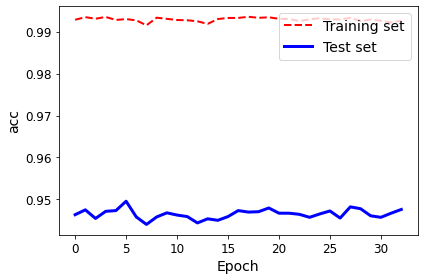

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


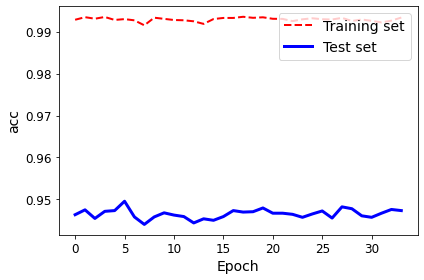

Saving figure MLP_nor_clf_learning_curve


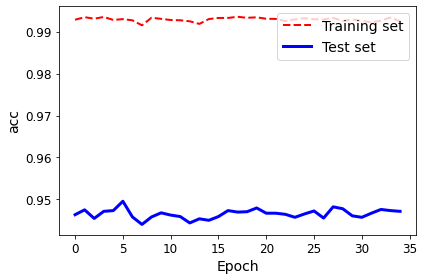

Saving figure MLP_nor_clf_learning_curve


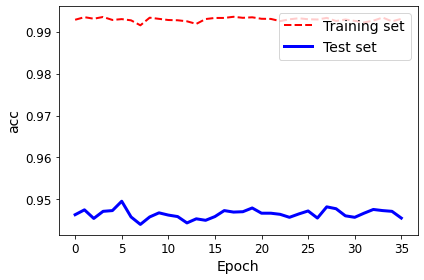

Saving figure MLP_nor_clf_learning_curve


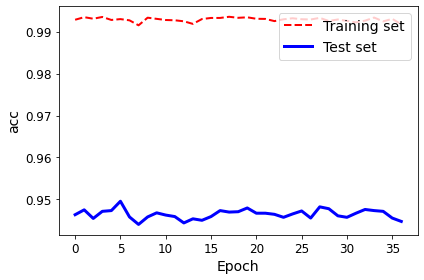

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


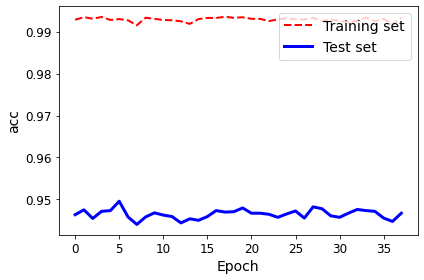

Saving figure MLP_nor_clf_learning_curve


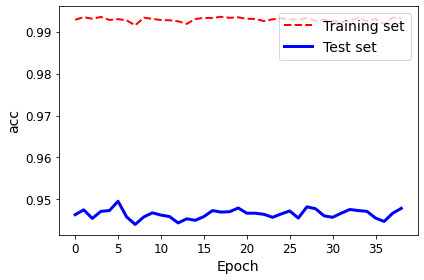

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


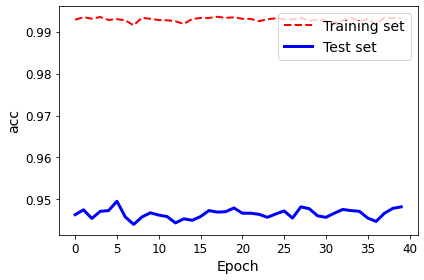

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


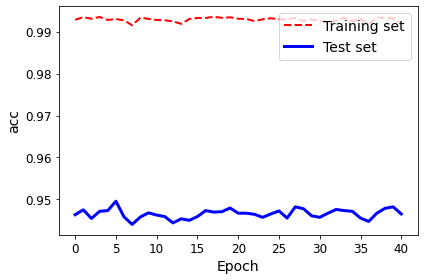

Saving figure MLP_nor_clf_learning_curve


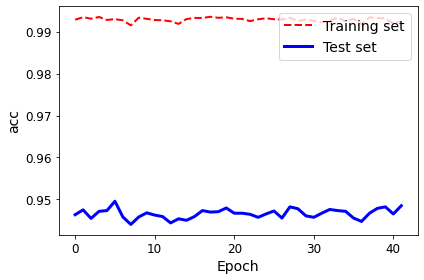

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


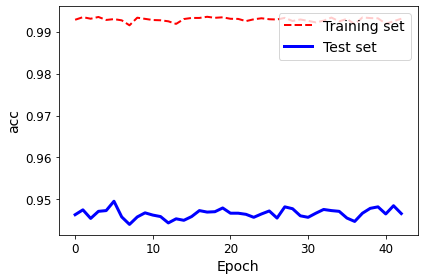

Saving figure MLP_nor_clf_learning_curve


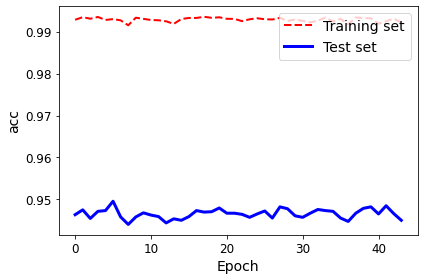

Saving figure MLP_nor_clf_learning_curve


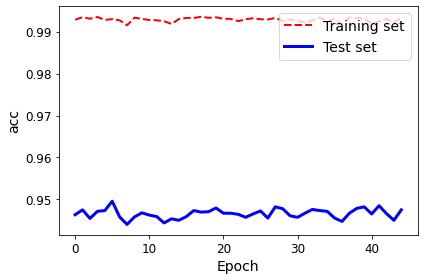

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


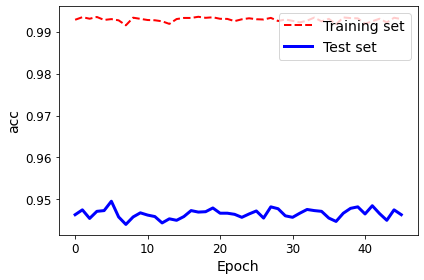

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


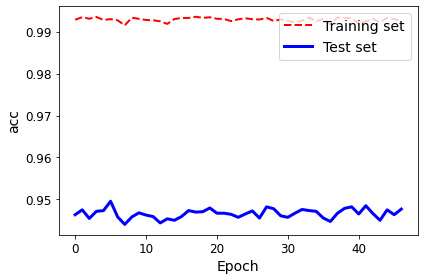

C:\Users\juniy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving figure MLP_nor_clf_learning_curve


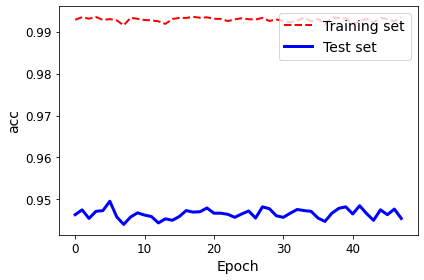

Saving figure MLP_nor_clf_learning_curve


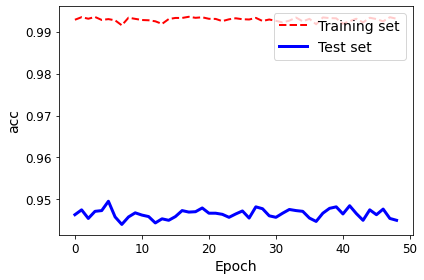

Saving figure MLP_nor_clf_learning_curve


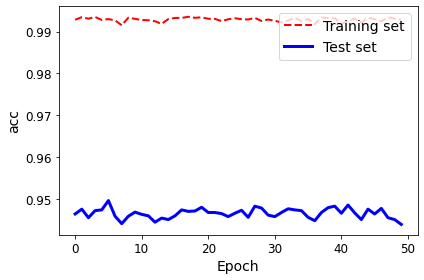

In [20]:
from sklearn.neural_network import MLPClassifier
mlp_nor_clf = MLPClassifier(alpha = 0.01)
n_epochs = 50
train_acc,test_acc = [],[]
for epoch in range(n_epochs):
    mlp_nor_clf.fit(X_train_normalized, y_train)
    train_acc.append(mlp_nor_clf.score(X_train_normalized, y_train))
    test_acc.append(mlp_nor_clf.score(X_test_normalized, y_test))
    #best_test_rmse -= 0.03  # just to make the graph look better
    plt.plot(train_acc, "r--", linewidth=2, label="Training set")
    plt.plot(test_acc, "b-", linewidth=3, label="Test set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    save_fig("MLP_nor_clf_learning_curve")
    plt.show()

- SVM Classifier 최적의 조건 탐색 

In [ ]:
for gamma in [0.01, 0.1, 1]:

    svm_nor_clf = SVC(gamma = gamma)
    svm_nor_clf.fit(X_train_normalized, y_train)

    y_predict = svm_nor_clf.predict(X_test_normalized)

    acc = accuracy_score(y_test, y_predict)
    print('gamma:', gamma,'->', 'acc:', acc)

    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    #'learning_rate': ['constant', 'invscaling', 'adaptive']
    #'C': [0.01, 0.1, 1, 10, 100]

gamma: 0.01 -> acc: 0.8488413547237077
gamma: 0.1 -> acc: 0.877361853832442
gamma: 1 -> acc: 0.9450089126559715


Saving figure SVM learning_curve


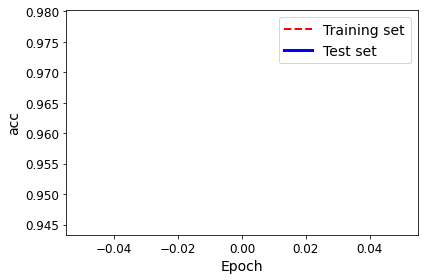

Saving figure SVM learning_curve


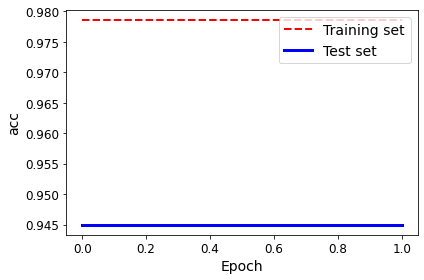

Saving figure SVM learning_curve


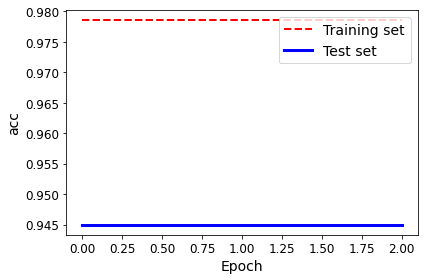

Saving figure SVM learning_curve


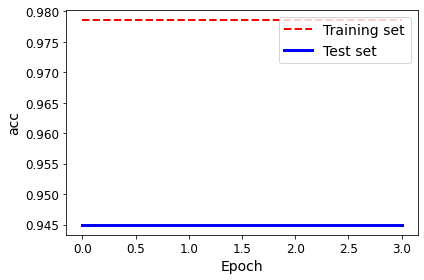

Saving figure SVM learning_curve


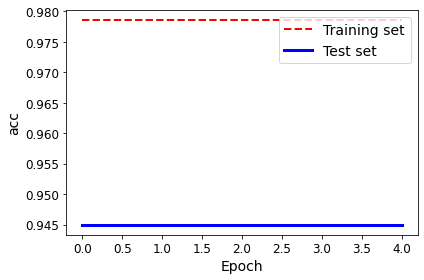

Saving figure SVM learning_curve


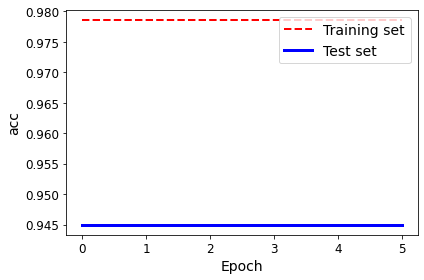

Saving figure SVM learning_curve


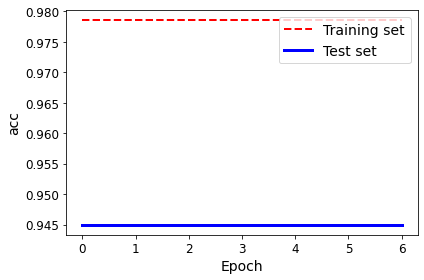

Saving figure SVM learning_curve


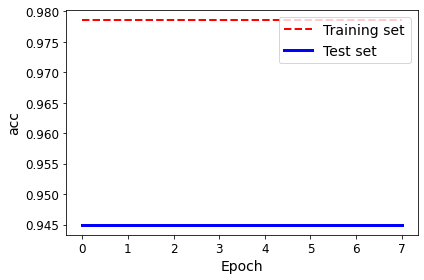

Saving figure SVM learning_curve


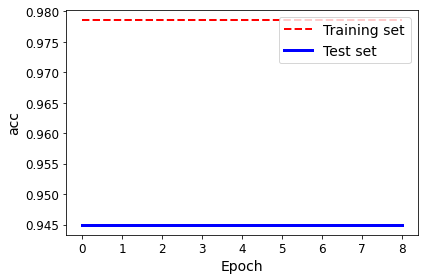

Saving figure SVM learning_curve


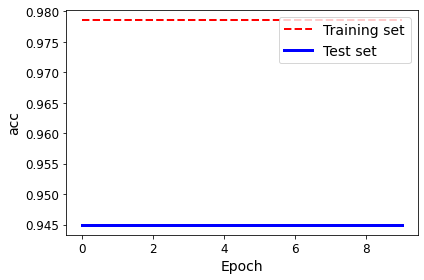

In [21]:
from sklearn.svm import SVC
svm_nor_clf = SVC(gamma = 1)
n_epochs = 10
train_acc,test_acc = [],[]
for epoch in range(n_epochs):
    svm_nor_clf.fit(X_train_normalized, y_train)
    train_acc.append(svm_nor_clf.score(X_train_normalized, y_train))
    test_acc.append(svm_nor_clf.score(X_test_normalized, y_test))
    #best_test_rmse -= 0.03  # just to make the graph look better
    plt.plot(train_acc, "r--", linewidth=2, label="Training set")
    plt.plot(test_acc, "b-", linewidth=3, label="Test set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    save_fig("SVM learning_curve")
    plt.show()